In [1]:
# https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np

In [4]:
import os
from os import listdir

In [5]:
DATA = "/kaggle/input"

In [6]:
# explore the input data
# for dirname, _, filenames in os.walk(DATA):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [7]:
train_directory = os.path.join(DATA,'feedback-prize-2021','train')

In [8]:
test_directory = os.path.join(DATA,'feedback-prize-2021','test')

In [9]:
glove_directory = os.path.join(DATA,'glovedata')

In [10]:
root_directory = os.path.join(DATA,'feedback-prize-2021')

In [11]:
# explore the word2vec datasets
for dirname, _, filenames in os.walk(glove_directory):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glovedata/glove.6B.200d.txt
/kaggle/input/glovedata/glove.6B.50d.txt
/kaggle/input/glovedata/glove.6B.100d.txt


In [12]:
train_filename = "train.csv"

In [13]:
train_filepath = os.path.join(root_directory,train_filename)

In [14]:
essay_files = listdir(train_directory)

In [15]:
len(essay_files)

15594

In [16]:
# to bring in the training set spreadsheet (.csv)

In [17]:
train_df = pd.read_csv(train_filepath)

In [18]:
train_df.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


In [19]:
print(len(train_df))

144293


In [20]:
def retrieveWordage(essay_id):
  essay_filename = essay_id + ".txt"
  essay_filepath = os.path.join(train_directory,essay_filename)
  with open(essay_filepath) as file:
    file_contents = file.read()
  #try:
  #  essay_text = pd.read_table(essay_filepath,header=0,engine='python',error_bad_lines=False)
  #except:
  #  return None
  #essay_text.columns = ['narrative']
  #return essay_text
  essay_text = []
  essay_line = ""
  for c in file_contents:
    if c == '\n':
      if len(essay_line) > 1:
        essay_text.append(essay_line)
      essay_line = ""
    else:
      essay_line += c
  essay_text.append(essay_line)
  essay_pd = pd.DataFrame(essay_text)
  essay_pd.columns = ['narrative']
  return essay_pd

In [21]:
wordage_test = retrieveWordage("0027FC00C35B")
print(wordage_test)

                                            narrative
0                                    Phones & Driving
1   Waking up from a wonderful dream, you look aro...
2   At this point you only have two options, are y...
3   In general, cell phones are a huge distraction...
4   In comparison, many other people may disagree ...
5   In my opinion, there shouldn't necessarily be ...
6   In conclusion, if causing harm and chaos is th...
7   Now back to the questions. Are you willing to ...
8                                          Work Cited
9   Ellis, Baldwin. "Pros of Driving & Cell Phone ...
10                                         Work Cited
11  Hilliard, Justin, et al. "Why You Really Shoul...
12                                         Work Cited
13  "Pros And Cons Of Using A Hands Free Mobile Ph...


In [22]:
def cleanText2(item):
  item2 = ""
  for ch in item:
      if ch == ' ' or (ch >= 'a' and ch <= 'z') or (ch >= 'A' and ch <= 'Z') or (ch >= '0' and ch <= '9'):
          if ch >= 'A' and ch <= 'Z':
              item2 += ch.lower()
          else:
              item2 += ch
  return item2

In [23]:
def retrieveEssay(essay_id):
  essay_text = retrieveWordage(essay_id)
  if essay_text is None:
        return None
  essay_count = len(essay_text)
  essay = ""
  for i in range(0,essay_count-1):
      essay += cleanText2(essay_text.iloc[i,0])
  return essay

In [24]:
def retrieveRawEssay(essay_id):
  essay_text = retrieveWordage(essay_id)
  if essay_text is None:
      return None
  essay_count = len(essay_text)
  essay = ""
  for i in range(0,essay_count-1):
      item = essay_text.iloc[i,0]
      essay += item
  return essay

In [25]:
essay_test = retrieveEssay("423A1CA112E2")
print(essay_test)

phonesmodern humans today are always on their phone they are always on their phone more than 5 hours a day no stop all they do is text back and forward and just have group chats on social media they even do it while driving they are some really bad consequences when stuff happens when it comes to a phone some certain areas in the united states ban phones from class rooms just because of itwhen people have phones they know about certain apps that they have apps like facebook twitter instagram and snapchat so like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages people always have different ways how to communicate with a phone phones have changed due to our generationdriving is one of the way how to get around people always be on their phones while doing it which can cause serious problems thats why theres a thing thats called no texting while driving thats a really important thing to remember some people still do it beca

In [26]:
from tensorflow.data import Dataset

In [27]:
from tensorflow.data import TextLineDataset

In [28]:
def retrieveDataset(essay_id):
  essay_array = []
  essay_text = retrieveWordage(essay_id)
  if essay_text is None:
    return None
  essay_count = len(essay_text)
  #essay = ""
  for i in range(0,essay_count-1):
      essay_array.append(cleanText2(essay_text.iloc[i,0]))
  #essay = essay_text.iloc[0,0]
  dataset = Dataset.from_tensor_slices(essay_array)
  return dataset

In [29]:
test_dataset = retrieveDataset("423A1CA112E2")
print(test_dataset)
for element in test_dataset:
    print(element)

<TensorSliceDataset shapes: (), types: tf.string>
tf.Tensor(b'phones', shape=(), dtype=string)
tf.Tensor(b'modern humans today are always on their phone they are always on their phone more than 5 hours a day no stop all they do is text back and forward and just have group chats on social media they even do it while driving they are some really bad consequences when stuff happens when it comes to a phone some certain areas in the united states ban phones from class rooms just because of it', shape=(), dtype=string)
tf.Tensor(b'when people have phones they know about certain apps that they have apps like facebook twitter instagram and snapchat so like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages people always have different ways how to communicate with a phone phones have changed due to our generation', shape=(), dtype=string)
tf.Tensor(b'driving is one of the way how to get around people always be on their phones whi

2022-02-28 23:37:39.976250: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [30]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [31]:
from tensorflow.keras.layers import TextVectorization

In [32]:
# Create the layer.
vectorize_layer = TextVectorization(
 max_tokens=5000,
 output_mode='int',
 output_sequence_length=500)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow import string as tf_string

In [34]:
def retrieveDiscourse(essay_id,discourse_id,discourse_start,discourse_end):
  essay_text = retrieveRawEssay(essay_id)
  essay_count = len(essay_text)
  i = 0
  discourse_text = ""
  for ch in essay_text:
     #print(ch)
     if i >= discourse_start -1 and i <= discourse_end:
        discourse_text += ch
     i += 1
  return cleanText2(discourse_text)

In [35]:
test_discourse = retrieveDiscourse("423A1CA112E2",0,8,229)
print(test_discourse)
print(len(test_discourse))

odern humans today are always on their phone they are always on their phone more than 5 hours a day no stop all they do is text back and forward and just have group chats on social media they even do it while driving th
219


In [36]:
# https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/pretrained_word_embeddings.ipynb#scrollTo=Q6j-LRMFc-AR

In [37]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [38]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import Model

In [39]:
essays_group = train_df.groupby(['id'])

In [40]:
class_dict = {}
samples = []
labels = []
class_index = 0
for essay_id, essay_pd in essays_group:  
  essay = retrieveEssay(essay_id)
  if essay is None:
    break
  discourse_count = len(essay_pd)
  for i in range(0,discourse_count):
    item = essay_pd.iloc[i,]
    discourse_id = item['discourse_id']
    discourse_start = item['discourse_start']
    discourse_end = item['discourse_end']
    discourse_type = item['discourse_type']
    discourse_type = discourse_type.lower()
    if class_dict.get(discourse_type) == None:
      class_name_index = class_index
      class_dict[discourse_type] = class_name_index
      class_index += 1
    else:
      class_name_index = class_dict.get(discourse_type)
    discourse = retrieveDiscourse(essay_id,discourse_id,discourse_start,discourse_end)
    samples.append(discourse)
    labels.append(class_name_index)

In [41]:
essay_array = []
samples_len = len(samples)
for i in range(0,samples_len):
  essay_text = samples[i]
  if essay_text != "":
      essay_array.append(essay_text)
vocab = Dataset.from_tensor_slices(essay_array)

In [42]:
# Now that the vocab layer has been created, call `adapt` on the text-only
# dataset to create the vocabulary. You don't have to batch, but for large
# datasets this means we're not keeping spare copies of the dataset.
vectorize_layer.adapt(vocab)

2022-02-28 23:50:08.816079: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [43]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [44]:
print(word_index)

{'': 0, '[UNK]': 1, 'the': 2, 'to': 3, 'a': 4, 'and': 5, 'of': 6, 'that': 7, 'in': 8, 'is': 9, 'you': 10, 'it': 11, 'they': 12, 'be': 13, 'for': 14, 'have': 15, 'are': 16, 'students': 17, 'not': 18, 'on': 19, 'can': 20, 'or': 21, 'i': 22, 'their': 23, 'would': 24, 'people': 25, 'if': 26, 'this': 27, 'with': 28, 'do': 29, 'because': 30, 'will': 31, 'more': 32, 'school': 33, 'but': 34, 'as': 35, 'we': 36, 'your': 37, 'at': 38, 'them': 39, 'get': 40, 'could': 41, 'there': 42, 'from': 43, 'what': 44, 'when': 45, 'so': 46, 'one': 47, 'all': 48, 'should': 49, 'by': 50, 'help': 51, 'an': 52, 'like': 53, 'was': 54, 'time': 55, 'also': 56, 'some': 57, 'about': 58, 'just': 59, 'make': 60, 'car': 61, 'cars': 62, 'many': 63, 'other': 64, 'who': 65, 'think': 66, 'has': 67, 'how': 68, 'work': 69, 'student': 70, 'electoral': 71, 'up': 72, 'dont': 73, 'out': 74, 'even': 75, 'college': 76, 'its': 77, 'he': 78, 'vote': 79, 'good': 80, 'know': 81, 'want': 82, 'may': 83, 'our': 84, 'my': 85, 'than': 86, '

In [45]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

In [46]:
path_to_glove_file = os.path.join(glove_directory,"glove.6B.100d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [47]:
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4801 words (199 misses)


In [48]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False,
)

In [49]:
class_names = []
for key in class_dict:
  print(key)
  class_names.append(key)

position
evidence
claim
counterclaim
rebuttal
concluding statement
lead


In [50]:
print(class_dict)
print(class_names)

{'position': 0, 'evidence': 1, 'claim': 2, 'counterclaim': 3, 'rebuttal': 4, 'concluding statement': 5, 'lead': 6}
['position', 'evidence', 'claim', 'counterclaim', 'rebuttal', 'concluding statement', 'lead']


In [51]:
# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
test_samples = samples[-num_validation_samples:]

In [52]:
print(len(train_samples))
print(len(test_samples))

115435
28858


In [53]:
train_labels = labels[0:len(train_samples)]
test_labels = labels[len(train_samples):(len(train_samples)+len(test_samples))]

In [54]:
# The class names should be the categories we are looking for.

In [55]:
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         500200    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         82048 

In [56]:
x_train = vectorize_layer(np.array([[s] for s in train_samples])).numpy()
x_test = vectorize_layer(np.array([[s] for s in test_samples])).numpy()

In [57]:
y_train = np.array([[s] for s in train_labels])
y_test = np.array([[s] for s in test_labels])

In [58]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)

In [59]:
#model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test))
model.fit(x_train, y_train, batch_size=128, epochs=20)
#model.fit(x_train,y_train)

Epoch 1/20
902/902 [==============================] - 253s 279ms/step - loss: 1.1248 - acc: 0.6432
Epoch 2/20
902/902 [==============================] - 251s 278ms/step - loss: 0.9817 - acc: 0.6824
Epoch 3/20
902/902 [==============================] - 250s 277ms/step - loss: 0.9079 - acc: 0.7055
Epoch 4/20
902/902 [==============================] - 249s 276ms/step - loss: 0.8682 - acc: 0.7170
Epoch 5/20
902/902 [==============================] - 249s 276ms/step - loss: 0.8375 - acc: 0.7262
Epoch 6/20
902/902 [==============================] - 249s 276ms/step - loss: 0.8176 - acc: 0.7322
Epoch 7/20
902/902 [==============================] - 249s 277ms/step - loss: 0.8015 - acc: 0.7373
Epoch 8/20
902/902 [==============================] - 249s 276ms/step - loss: 0.7869 - acc: 0.7410
Epoch 9/20
902/902 [==============================] - 251s 279ms/step - loss: 0.7782 - acc: 0.7432
Epoch 10/20
902/902 [==============================] - 249s 276ms/step - loss: 0.7639 - acc: 0.7480
Epoch 11/

In [60]:
y_result = model.predict(x_test)

In [61]:
print(y_result)

[[6.2424672e-01 2.7598312e-02 2.9396206e-01 ... 1.2933262e-02
  3.1901773e-02 3.1838750e-03]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.1298360e-33]
 [1.1300070e-03 7.2199267e-01 2.1620321e-01 ... 1.3900375e-02
  1.9649578e-04 4.5034338e-02]
 ...
 [7.4637055e-02 1.6858573e-01 1.3318390e-01 ... 2.9679678e-02
  5.5120367e-01 1.0580325e-02]
 [7.4637055e-02 1.6858573e-01 1.3318390e-01 ... 2.9679663e-02
  5.5120367e-01 1.0580325e-02]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


In [62]:
yt0 = y_test[1]

In [63]:
y_rounded = np.round(y_result,1)

In [64]:
y0 = y_rounded[1]

In [65]:
print(y0)

[0. 1. 0. 0. 0. 0. 0.]


In [66]:
print(yt0)

[1]


In [67]:
print(len(y_rounded))
print(len(y_test))

28858
28858


In [68]:
for i in range(0,10):
    y_out = y_rounded[i]
    yt = y_test[i]
    print(y_out)
    print(yt)

[0.6 0.  0.3 0.  0.  0.  0. ]
[2]
[0. 1. 0. 0. 0. 0. 0.]
[1]
[0.  0.7 0.2 0.  0.  0.  0. ]
[1]
[0.1 0.1 0.7 0.  0.  0.  0. ]
[2]
[0.  0.9 0.  0.  0.  0.  0. ]
[1]
[0.1 0.2 0.1 0.  0.  0.6 0. ]
[2]
[0.1 0.2 0.1 0.  0.  0.6 0. ]
[1]
[0.2 0.1 0.1 0.  0.  0.6 0. ]
[0]
[0.2 0.1 0.6 0.  0.  0.  0.1]
[2]
[0.1 0.2 0.4 0.  0.1 0.1 0. ]
[2]


In [69]:
# Create Statistics about Where Discourses are in Essays
# To do this we first create a pandas dataframe 'essay_statistics', per essay it lists
# essay_id,essay_length (in characters),discourse_count
class_dict = {}
samples = []
labels = []
class_index = 0
length_of_essay = 0
stats = []
for essay_id, essay_pd in essays_group: 
  stats_entry = []
  stats_entry.append(essay_id)
  essay = retrieveEssay(essay_id)
  if essay is None:
    break
  length_of_essay = len(essay)
  stats_entry.append(length_of_essay)
  discourse_count = len(essay_pd)
  stats_entry.append(discourse_count)
  stats.append(stats_entry)
essay_statistics = pd.DataFrame(stats)

In [70]:
essay_statistics.head()

,0,1,2
0,0000D23A521A,985,8
1,00066EA9880D,3065,9
2,000E6DE9E817,1488,12
3,001552828BD0,2473,10
4,0016926B079C,1023,11


In [71]:
essay_statistics.columns = ['essay_id','essay_length','no_of_discourses']

In [72]:
essay_statistics.head()

,essay_id,essay_length,no_of_discourses
0,0000D23A521A,985,8
1,00066EA9880D,3065,9
2,000E6DE9E817,1488,12
3,001552828BD0,2473,10
4,0016926B079C,1023,11


In [73]:
import matplotlib.pyplot as plt

In [74]:
x = essay_statistics['essay_length']
y = essay_statistics['no_of_discourses']

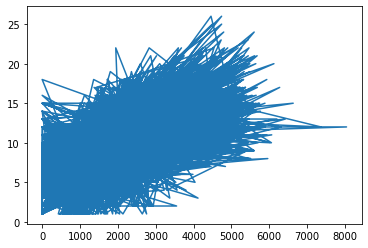

In [75]:
plt.plot(x,y)

In [76]:
# https://realpython.com/numpy-scipy-pandas-correlation-python/#visualization-of-correlation

In [77]:
x.corr(y)

0.6120847388095774

In [78]:
y.corr(x)

0.6120847388095775

In [80]:
from scipy import stats as sci_stats

In [82]:
#https://realpython.com/numpy-scipy-pandas-correlation-python/#visualization-of-correlation
slope, intercept, r, p, stderr = sci_stats.linregress(x, y)

In [83]:
print(slope)
print(intercept)
print(r)
print(p)
print(stderr)

0.0018152953177363788
5.81630132079024
0.6120847388095774
0.0
1.878223150704505e-05


In [84]:
def returnExpectedDiscourses(essay_length):
    yyy = intercept + essay_length * slope
    return yyy

In [92]:
discourse_num_err = np.round(r,0)

In [93]:
print(discourse_num_err)

1.0


In [94]:
print(returnExpectedDiscourses(1000))

7.631596638526618


In [95]:
sample_x = []
sample_y = []
for i in range(0,8000,500):
    yy = returnExpectedDiscourses(i)
    sample_x.append(i)
    sample_y.append(yy)

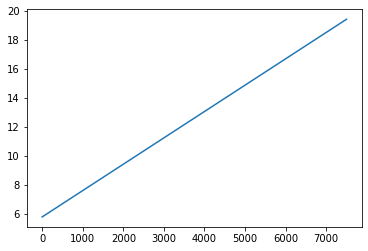

In [96]:
plt.plot(sample_x,sample_y)

In [98]:
essay_test = retrieveEssay("423A1CA112E2")
print(essay_test)

phonesmodern humans today are always on their phone they are always on their phone more than 5 hours a day no stop all they do is text back and forward and just have group chats on social media they even do it while driving they are some really bad consequences when stuff happens when it comes to a phone some certain areas in the united states ban phones from class rooms just because of itwhen people have phones they know about certain apps that they have apps like facebook twitter instagram and snapchat so like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages people always have different ways how to communicate with a phone phones have changed due to our generationdriving is one of the way how to get around people always be on their phones while doing it which can cause serious problems thats why theres a thing thats called no texting while driving thats a really important thing to remember some people still do it beca

In [99]:
length_of_essay = len(essay_test)
expected_discourses = returnExpectedDiscourses(length_of_essay)
print(length_of_essay)
print(expected_discourses)

1487
8.515645458264235


In [151]:
expected_discourses = 13

In [152]:
# Start out with all discourses of even length
test_discourse = []
length_of_discourses = round(length_of_essay/expected_discourses,0)
print(length_of_discourses)

114.0


In [153]:
text_start = 0
discourse_element = []
test_discourse = []
for i in range(1,int(expected_discourses)):
    #print(i)
    text_end = text_start + length_of_discourses
    discourse_element.append(text_start)
    discourse_element.append(text_end)
    text_start = text_end + 1
    test_discourse.append(discourse_element)
    discourse_element = []
text_start = text_end + 1
text_end = length_of_essay
discourse_element.append(text_start)
discourse_element.append(text_end)
test_discourse.append(discourse_element)

In [119]:
print(int(expected_discourses))
print(length_of_essay)
print(test_discourse)

9
1487
[[0, 165.0], [166.0, 331.0], [332.0, 497.0], [498.0, 663.0], [664.0, 829.0], [830.0, 995.0], [996.0, 1161.0], [1162.0, 1327.0], [1328.0, 1487]]


In [120]:
print(len(essay_test))

1487


In [154]:
x_discourses = []
for discourse in test_discourse:
    print(discourse)
    start_text = int(discourse[0])
    end_text = int(discourse[1])
    discourse_element = ""
    for i in range(start_text,end_text):
        discourse_element += essay_test[i]
    x_discourses.append(discourse_element)

[0, 114.0]
[115.0, 229.0]
[230.0, 344.0]
[345.0, 459.0]
[460.0, 574.0]
[575.0, 689.0]
[690.0, 804.0]
[805.0, 919.0]
[920.0, 1034.0]
[1035.0, 1149.0]
[1150.0, 1264.0]
[1265.0, 1379.0]
[1380.0, 1487]


In [122]:
print(x_discourses)

['phonesmodern humans today are always on their phone they are always on their phone more than 5 hours a day no stop all they do is text back and forward and just have', 'group chats on social media they even do it while driving they are some really bad consequences when stuff happens when it comes to a phone some certain areas in the', 'united states ban phones from class rooms just because of itwhen people have phones they know about certain apps that they have apps like facebook twitter instagram ', 'nd snapchat so like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages people always have different ', 'ays how to communicate with a phone phones have changed due to our generationdriving is one of the way how to get around people always be on their phones while doing', 'it which can cause serious problems thats why theres a thing thats called no texting while driving thats a really important thing to remember some people

In [155]:
x_test = vectorize_layer(np.array([[s] for s in x_discourses])).numpy()

In [124]:
print(x_test)

[[   1  334  478 ...    0    0    0]
 [ 506    1   19 ...    0    0    0]
 [ 335  103  704 ...    0    0    0]
 ...
 [  30   12   66 ...    0    0    0]
 [   1   21    4 ...    0    0    0]
 [ 384 1780   10 ...    0    0    0]]


In [156]:
y_result = model.predict(x_test)

In [126]:
print(y_result)

[[3.0482313e-02 3.9501107e-01 4.1303635e-01 2.2557698e-02 7.1429268e-02
  3.3321459e-02 3.4161922e-02]
 [4.8592351e-02 2.8524774e-01 5.0812286e-01 2.7899483e-02 8.8440247e-02
  2.7366975e-02 1.4330336e-02]
 [1.6338314e-32 9.9997735e-01 9.3906883e-17 9.3957118e-38 7.2562484e-27
  1.8911241e-33 2.2676635e-05]
 [9.3723129e-04 6.3987577e-01 2.7882627e-01 4.7197095e-03 5.2448779e-02
  2.2669263e-02 5.2304909e-04]
 [9.6573278e-02 3.8721815e-01 1.4553674e-01 7.3625259e-03 3.7135419e-02
  2.7549157e-01 5.0682262e-02]
 [6.5101795e-02 1.3635175e-01 4.8176733e-01 1.7789504e-01 7.9740897e-02
  3.6656165e-03 5.5477567e-02]
 [4.3038889e-03 4.2341918e-02 6.1140448e-01 2.0181757e-01 1.3976628e-01
  5.0513986e-06 3.6084751e-04]
 [6.1782021e-02 3.1097654e-01 5.2223051e-01 9.6477214e-03 4.9885146e-02
  3.1191867e-02 1.4286276e-02]
 [6.9118934e-03 4.7147948e-01 4.2771360e-01 9.6076783e-03 6.2025718e-02
  7.0715239e-03 1.5190107e-02]]


In [157]:
# Given the test result, compute the score
def computeScore(y_result):
    cumulative_score = 0
    number_of_items = 0
    for item in y_result:
        max_score = 0
        for score in item:
            if max_score < score:
                max_score = score
        cumulative_score += max_score
        number_of_items += 1
    #print(number_of_items)
    return cumulative_score / number_of_items

computeScore(y_result)

0.6982623499173385

In [ ]:
# 8 
# 0.5768586434423923
# 9
# 0.5594
# 10
# 0.4849
# 11
# 0.4849
# 12
# 0.6639
# 13
# 0.698

In [111]:
es = train_df[train_df['id']=="423A1CA112E2"]
print(es)

             id  discourse_id  discourse_start  discourse_end  \
0  423A1CA112E2  1.622628e+12              8.0          229.0   
1  423A1CA112E2  1.622628e+12            230.0          312.0   
2  423A1CA112E2  1.622628e+12            313.0          401.0   
3  423A1CA112E2  1.622628e+12            402.0          758.0   
4  423A1CA112E2  1.622628e+12            759.0          886.0   
5  423A1CA112E2  1.622628e+12            887.0         1150.0   
6  423A1CA112E2  1.622628e+12           1151.0         1533.0   
7  423A1CA112E2  1.622628e+12           1534.0         1602.0   
8  423A1CA112E2  1.622628e+12           1603.0         1890.0   
9  423A1CA112E2  1.622628e+12           1891.0         2027.0   

                                      discourse_text        discourse_type  \
0  Modern humans today are always on their phone....                  Lead   
1  They are some really bad consequences when stu...              Position   
2  Some certain areas in the United States ban ph.

In [112]:
print(len(y_result))

8
